In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from colors import strip_color
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime
import array
import math
from scipy.stats import norm

sns.set_style("whitegrid")

In [3]:
LOG_PATH = Path('./log/')

In [39]:
def get_files(extension, committee_size, latency, long=True):
    log_folder = '%s_%d_%d' % (extension, committee_size, latency)
    if long == True:
        log_folder += '_long'
    data_path = LOG_PATH / log_folder
    log_files = [x for x in data_path.iterdir() if x.name.endswith('.log')]
    dstat_files = [x for x in data_path.iterdir() if x.name.endswith('.csv')]
    return log_files, dstat_files

In [81]:
def _sanitize(s):
    s = strip_color(s)
    s = s.strip('[1;38;5;8m')
    s = s.strip('\n')
    return s

def _get_time(s):
    dt_str = s[0:23]
    return datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S.%f')

def get_blocks(log_file):
    blocks = dict()
    for line in open(log_file.absolute()):
        block = dict()
        line = _sanitize(line)
        if line.find('Block submitted via CPU miner accepted') != -1: # mined a block
            blockhash = line.split(' ')[-4].strip(',')
            if blockhash not in blocks.keys():
                blocks[blockhash] = dict()
            if 'mined_time' not in blocks[blockhash]:
                blocks[blockhash]['mined_time'] = _get_time(line)
        if line.find('PEER: Received block (hash') != -1: # received a block
            blockhash = line.split(' ')[7].strip(',')
            if blockhash not in blocks.keys():
                blocks[blockhash] = dict()
            if 'received_time' not in blocks[blockhash]:
                blocks[blockhash]['received_time'] = _get_time(line)
        if line.find('has been finalised') != -1: # finalised
            blockhash = line.split(' ')[-4]
            if blockhash not in blocks.keys():
                blocks[blockhash] = dict()
            if 'finalised_time' not in blocks[blockhash]:
                blocks[blockhash]['finalised_time'] = _get_time(line)
    
    blockhash_to_remove = list()
    for blockhash in blocks.keys():
        if 'finalised_time' not in blocks[blockhash] or len(blocks[blockhash]) < 2:
            blockhash_to_remove.append(blockhash)
            continue
        
        if 'mined_time' in blocks[blockhash].keys(): # this block is mined by this miner
            blocks[blockhash]['time_to_finalise'] = blocks[blockhash]['finalised_time'] - blocks[blockhash]['mined_time']
        elif 'received_time' in blocks[blockhash].keys(): # this block is mined by other miners
            blocks[blockhash]['time_to_finalise'] = blocks[blockhash]['finalised_time'] - blocks[blockhash]['received_time']
    
    for blockhash in blockhash_to_remove:
        del blocks[blockhash]
    
    return blocks

lfiles, dfiles = get_files('syncorazor', 4, 5, long=True)
blocks = get_blocks(lfiles[2])
for blockhash in blocks.keys():
    print(blocks[blockhash])

{'received_time': datetime.datetime(2022, 3, 15, 2, 3, 46, 247000), 'finalised_time': datetime.datetime(2022, 3, 15, 2, 4, 1, 248000), 'time_to_finalise': datetime.timedelta(seconds=15, microseconds=1000)}
{'received_time': datetime.datetime(2022, 3, 15, 2, 4, 6, 287000), 'finalised_time': datetime.datetime(2022, 3, 15, 2, 4, 21, 288000), 'time_to_finalise': datetime.timedelta(seconds=15, microseconds=1000)}
{'received_time': datetime.datetime(2022, 3, 15, 2, 4, 26, 326000), 'finalised_time': datetime.datetime(2022, 3, 15, 2, 4, 41, 327000), 'time_to_finalise': datetime.timedelta(seconds=15, microseconds=1000)}
{'received_time': datetime.datetime(2022, 3, 15, 2, 4, 46, 365000), 'finalised_time': datetime.datetime(2022, 3, 15, 2, 5, 1, 366000), 'time_to_finalise': datetime.timedelta(seconds=15, microseconds=1000)}
{'received_time': datetime.datetime(2022, 3, 15, 2, 5, 6, 405000), 'finalised_time': datetime.datetime(2022, 3, 15, 2, 5, 21, 406000), 'time_to_finalise': datetime.timedelta(s

## Block propagation/finalisation delay

In [82]:
def get_finalisation_delay(extension, committee_size, latency):
    # dict{block: [gap1, gap2, ...]}
    times_dict = dict()
    lfiles, _ = get_files(extension, committee_size, latency)
    for lf in lfiles:
        blocks = get_blocks(lf)
        for blockhash, block in blocks.items():
            if blockhash not in times_dict.keys():
                times_dict[blockhash] = list()
            times_dict[blockhash].append(block['time_to_finalise'])
    
    return times_dict

get_finalisation_delay('syncorazor', 4, 5)

{'581163024944f4d436ff593475a2691a2a82a09aa4bb45c291491818bd2e49e0': [datetime.timedelta(seconds=15, microseconds=1000),
  datetime.timedelta(seconds=15, microseconds=1000),
  datetime.timedelta(seconds=15, microseconds=1000),
  datetime.timedelta(seconds=15)],
 '6b1c2e991e27ac38af6c6a078fe949dd6cddbf9296c88b688242657b7b51563a': [datetime.timedelta(seconds=15, microseconds=1000),
  datetime.timedelta(seconds=15),
  datetime.timedelta(seconds=15, microseconds=1000),
  datetime.timedelta(seconds=15, microseconds=1000)],
 '454112f0194e59e9875b9c40d40ca96541231a3789aa9f2f723fe7259f099fe5': [datetime.timedelta(seconds=15, microseconds=1000),
  datetime.timedelta(seconds=15, microseconds=1000),
  datetime.timedelta(seconds=15, microseconds=1000),
  datetime.timedelta(seconds=15, microseconds=1000)],
 '2bffa3210d8e56660a6bace6276b853589d4183e0ad8e794ffe5d4a9a52900e8': [datetime.timedelta(seconds=15, microseconds=1000),
  datetime.timedelta(seconds=15, microseconds=1000),
  datetime.timedelta(

## Network bandwidth utilisation

- Definition: average used bandwidth per node
- Example: [HydRand paper](https://eprint.iacr.org/2018/319.pdf) Appendix A
- Method: On every node, run `dstat`
- Expected result: much better than other protocols

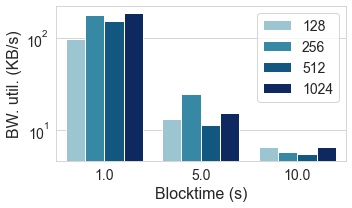

In [7]:
def get_bw_util(blocktime, num_nodes, num_miners):
    _, dfiles = get_files(blocktime, num_nodes, num_miners)
    recvs, sends = [], []
    for dfile in dfiles:
        df = pd.read_csv(dfile.absolute(), skiprows=6)
        recvs.append(df['recv'].mean())
        sends.append(df['send'].mean())
    return np.array(recvs).mean(), np.array(sends).mean() # all in Bytes

get_bw_util(10, 128, 8)

def plot_bw_util_both():
    blocktimes = [1, 5, 10]
    
    nodes = np.array([128, 256, 512, 1024])
    
    plt.figure(0, figsize=(6, 4))
    df = pd.DataFrame(columns=['Blocktime', 'Number of nodes', 'Bandwidth utilisation'])
    for bt in blocktimes:
        for n in nodes:
            bw_series = pd.Series(data=[bt, n, get_bw_util(bt, n/8, 8)[0] / 1000], index=['Blocktime', 'Number of nodes', 'Bandwidth utilisation'])
            df = df.append(bw_series, ignore_index=True)
    
    ax = sns.barplot(x="Blocktime", y="Bandwidth utilisation", hue="Number of nodes", data=df)
    ax.set(yscale="log")
    ax.set_xlabel('Blocktime (s)',fontsize=20)
    ax.set_ylabel('Used BW. (KB/s)',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    leg = plt.legend(ncol=2, fontsize=16)
    for t in leg.texts:
        t.set_text('%d' % float(t.get_text()))

    plt.tight_layout()
    plt.savefig('../../randchain-paper/paper/figs/bw-util-in.pdf')
    plt.show()
    plt.close()
    
    plt.figure(0, figsize=(6, 4))
    df = pd.DataFrame(columns=['Blocktime', 'Number of nodes', 'Bandwidth utilisation'])
    for bt in blocktimes:
        for n in nodes:
            bw_series = pd.Series(data=[bt, n, get_bw_util(bt, n/8, 8)[1] / 1000], index=['Blocktime', 'Number of nodes', 'Bandwidth utilisation'])
            df = df.append(bw_series, ignore_index=True)
    
    ax = sns.barplot(x="Blocktime", y="Bandwidth utilisation", hue="Number of nodes", data=df)
    ax.set(yscale="log")
    ax.set_xlabel('Blocktime (s)',fontsize=20)
    ax.set_ylabel('Used BW. (KB/s)',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    leg = plt.legend(ncol=2, fontsize=16)
    for t in leg.texts:
        t.set_text('%d' % float(t.get_text()))

    plt.tight_layout()
    plt.savefig('../../randchain-paper/paper/figs/bw-util-out.pdf')
    plt.show()
    plt.close()
    
def plot_bw_util():
    blocktimes = [1, 5, 10]
    nodes = np.array([128, 256, 512, 1024])
    
    plt.figure(0, figsize=(5, 3))
    df = pd.DataFrame(columns=['Blocktime', 'Number of nodes', 'Bandwidth utilisation'])
    for bt in blocktimes:
        for n in nodes:
            bws = get_bw_util(bt, n/8, 8)
            total_bw = bws[0] + bws[1]
            bw_series = pd.Series(data=[bt, n, total_bw / 1000], index=['Blocktime', 'Number of nodes', 'Bandwidth utilisation'])
            df = df.append(bw_series, ignore_index=True)
    
    ax = sns.barplot(x="Blocktime", y="Bandwidth utilisation", hue="Number of nodes", data=df, palette=sns.color_palette('ocean_r'))
    
    # hatches = ['xx', '++', '//', '\\\\']
    # for i, thisbar in enumerate(ax.patches):
    #     thisbar.set_hatch(hatches[int(np.floor(i/3))])
    
    ax.set(yscale="log")
    ax.set_xlabel('Blocktime (s)',fontsize=16)
    ax.set_ylabel('BW. util. (KB/s)',fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    leg = plt.legend(ncol=1, fontsize=14)
    for t in leg.texts:
        t.set_text('%d' % float(t.get_text()))

    plt.tight_layout()
    plt.savefig('../../randchain-paper/paper/figs/bw-util.pdf')
    plt.show()
    plt.close()

plot_bw_util()